Sequential sampling (2 chains in 1 job)
Metropolis: [n]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sequential sampling (2 chains in 1 job)
Metropolis: [n]
C:\Python313\Lib\site-packages\pytensor\scalar\basic.py:2052: RuntimeWarning: invalid value encountered in scalar subtract
  return x - y
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sequential sampling (2 chains in 1 job)
Metropolis: [n]
C:\Python313\Lib\site-packages\pytensor\scalar\basic.py:2052: RuntimeWarning: invalid value encountered in scalar subtract
  return x - y
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of conv

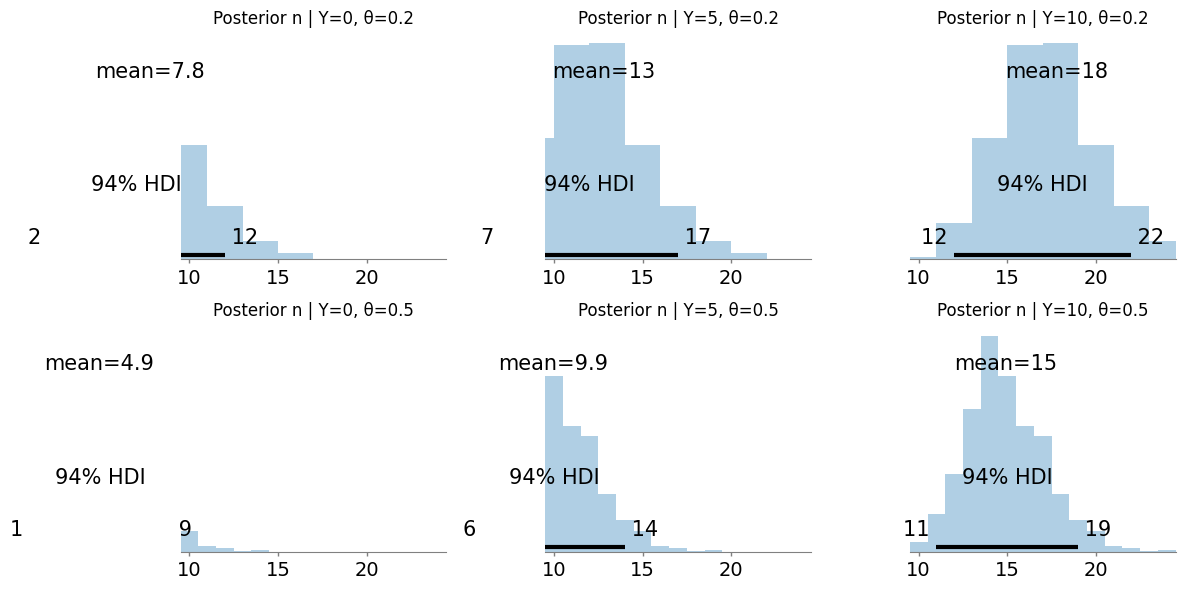

In [9]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

thetas = [0.2, 0.5]
ys = [0, 5, 10]

posterior_traces = {}

fig, axes = plt.subplots(
    nrows=len(thetas),
    ncols=len(ys),
    figsize=(12, 6),
    sharex=True
)

for i, theta in enumerate(thetas):
    for j, y in enumerate(ys):
        with pm.Model() as model:
            # prior: n ~ Poisson(10)
            n = pm.Poisson("n", mu=10)

            # observabil: Y_obs ~ Binomial(n, theta)
            Y_obs = pm.Binomial("Y_obs", n=n, p=theta, observed=y)

            # sampling din posteriorul lui n
            trace = pm.sample(
                draws=2000,
                tune=2000,
                chains=2,
                cores=1,                 # aparent pe windows e mai sigur cu 1 core
                return_inferencedata=True,
                progressbar=False,
                random_seed=123,
            )

        posterior_traces[(theta, y)] = trace

        ax = axes[i, j]
        az.plot_posterior(trace, var_names=["n"], ax=ax)
        ax.set_title(f"Posterior n | Y={y}, θ={theta}") #pentru fiecare caz, obtinem histograma care spune Cât de plauzibil este fiecare număr de clienți n, știind că am observat Y cumpărători cu probabilitatea de cumpărare θ?”

plt.tight_layout()
plt.show()

#fara date, n era aproximativ Poisson(10) (varful pe la 10), dar cu date (Y), se muta, la ingusteaza sau se lateste, in functie de cat de compatibile sunt valorile de n cu ce am observat

b) -> efectul lui Y (cu θ fix): daca Y creste, distributia se va muta spre valori mai mari, media posteriorului creste, iar probabilitatea pentru valori mici a lui n scade (adica nu mai pot produce suficienti cumparatori cu probabilitatea θ)

   -> efectul lui θ: θ e probabilitatea ca un client sa cumpere acel produs. Pentru acelasi Y, daca θ e mai mare, avem nevoie de mai putini clienti n ca sa obtinem aceiasi Y cumparatori


   Deci:

daca θ e mai mare => posteriorul lui n se muta spre stanga (n mai mic)

daca θ е mai mic => posteriorul lui n se muta spre dreapta (n mai mare)



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [Y_future]
C:\Python313\Lib\site-packages\pytensor\scalar\basic.py:2052: RuntimeWarning: invalid value encountered in scalar subtract
  return x - y
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [Y_future]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [Y_future]
C:\Python313\Lib\site-packages\pytensor\scalar\basic.py:2052: RuntimeWarning: invalid value encountered in scalar subtract
  return x - y
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [Y_future]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [Y_future]
C:\Python313\Lib

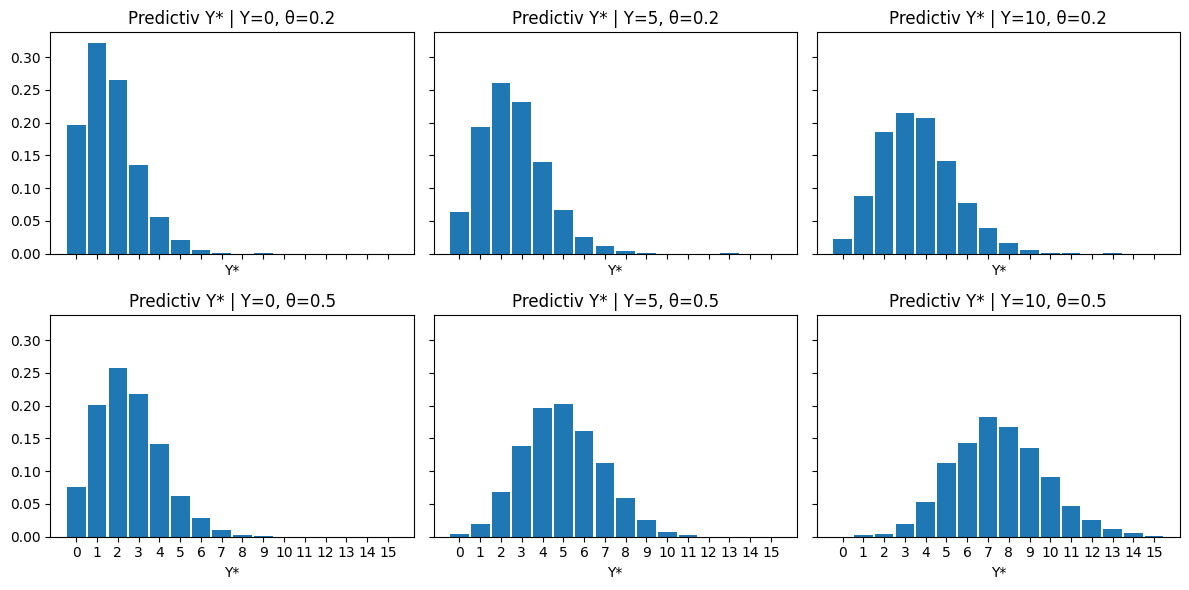

In [10]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

thetas = [0.2, 0.5]
ys = [0, 5, 10]

predictive_samples = {}

fig, axes = plt.subplots(
    nrows=len(thetas),
    ncols=len(ys),
    figsize=(12, 6),
    sharex=True,
    sharey=True
)

for i, theta in enumerate(thetas):
    for j, y in enumerate(ys):
        with pm.Model() as model:
            # prior pentru numarul total de clienti
            n = pm.Poisson("n", mu=10)

            # numarul de cumparatori observati
            Y_obs = pm.Binomial("Y_obs", n=n, p=theta, observed=y)

            # numarul viitor de cumparatori Y*
            Y_future = pm.Binomial("Y_future", n=n, p=theta)

            # esantionare din posteriorul lui n
            trace = pm.sample(
                draws=2000,
                tune=2000,
                chains=2,
                cores=1,
                return_inferencedata=True,
                progressbar=False,
                random_seed=123,
            )

            # esantionare din distributia predictiva p(Y* | date)
            # => cerem explicit un dict, nu InferenceData
            ppc = pm.sample_posterior_predictive(
                trace,
                var_names=["Y_future"],
                progressbar=False,
                random_seed=123,
                return_inferencedata=False,
            )

        y_star = ppc["Y_future"].ravel()
        predictive_samples[(theta, y)] = y_star

        ax = axes[i, j]
        az.plot_dist(y_star, ax=ax)
        ax.set_title(f"Predictiv Y* | Y={y}, θ={theta}")
        ax.set_xlabel("Y*")

plt.tight_layout()
plt.show()


Diferenta dintre P(n|Y,θ) si P(Y*|n,θ)

- P(n|Y,θ) este distributia a numarului de clienti n, stiind Y cumparatori cu probabilitatea de cumparare θ; raspunde la intrebarea "Cati clienti au fost in ziua pe care am observat-o?". Este o distributie peste cauza latenta (n), avand in vedere datele (Y, θ) si e ce se afla in graficele de la a)

- P(Y*|n,θ) este distributia a numarului de cumparatori Y*, stiind n clienti cu probabilitatea de cumparare θ si raspunde la intrebarea "Cati cumparatori vom avea intr-o zi viitoare, daca avem aceeasi situatie (θ) si am observat deja Y azi?"

Intuitiv:

Posterior n = tratam ziua curenta ca un mister: cati clienti au fost, luand in calcul ce am observat?

Predictiv Y* = acum, folosind ce am invatat despre n si θ, la ce rezultate ne asteptam pentru o noua zi/ziua urmatoare?